In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, classification_report



## Load dataset

In [2]:
#Loading the data set - training data.
Dataset = fetch_20newsgroups(subset='all', shuffle=True, remove = ('headers', 'footers', 'quotes'), random_state=42)
print('Data set size:', len(Dataset['data']))

Data set size: 18846


In [3]:
# Finding frequency of each category
targets, frequency = np.unique(Dataset.target, return_counts=True)
targets_str = np.array(Dataset.target_names)
print(list(zip(targets_str, frequency)))



[('alt.atheism', 799), ('comp.graphics', 973), ('comp.os.ms-windows.misc', 985), ('comp.sys.ibm.pc.hardware', 982), ('comp.sys.mac.hardware', 963), ('comp.windows.x', 988), ('misc.forsale', 975), ('rec.autos', 990), ('rec.motorcycles', 996), ('rec.sport.baseball', 994), ('rec.sport.hockey', 999), ('sci.crypt', 991), ('sci.electronics', 984), ('sci.med', 990), ('sci.space', 987), ('soc.religion.christian', 997), ('talk.politics.guns', 910), ('talk.politics.mideast', 940), ('talk.politics.misc', 775), ('talk.religion.misc', 628)]


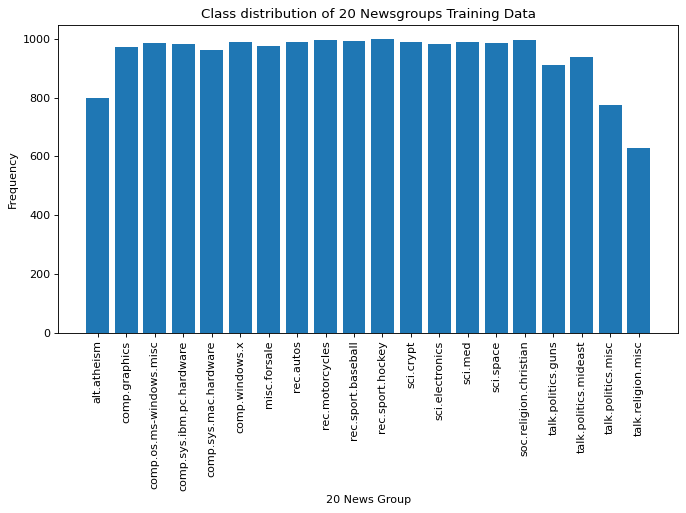

In [4]:
# Training data class distribution
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(targets_str,frequency)
plt.xticks(rotation=90)
plt.title('Class distribution of 20 Newsgroups Training Data')
plt.xlabel('20 News Group')
plt.ylabel('Frequency')
plt.show()



## Data Preparation

In [5]:
ds_df = pd.DataFrame({'data': Dataset.data, 'target': Dataset.target})
ds_df.head()

,data,target
0,\n\nI am sure some bashers of Pens fans are pr...,10
1,My brother is in the market for a high-perform...,3
2,\n\n\n\n\tFinally you said what you dream abou...,17
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3
4,1) I have an old Jasmine drive which I cann...,4


In [6]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
import re
import string

alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

ds_df['data'] = ds_df.data.map(alphanumeric).map(punc_lower)
ds_df.head()



,data,target
0,\n\ni am sure some bashers of pens fans are pr...,10
1,my brother is in the market for a high perform...,3
2,\n\n\n\n\tfinally you said what you dream abou...,17
3,\nthink \n\nit s the scsi card doing the dma t...,3
4,i have an old jasmine drive which i cann...,4


## Stemming and Lemmatization

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words=stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# import seaborn as sns
# sns.set(style='white')
# sns.set(style='whitegrid', color_codes=True)

In [9]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def remove_stop_words(text):
    tokens = word_tokenize(text)
    return TreebankWordDetokenizer().detokenize([f.lower() for f in tokens if f and f.lower() not in stop_words])

def remove_non_leters(text):
  tokens = [word.strip(string.punctuation) for word in RegexpTokenizer(r'\b[a-zA-Z][a-zA-Z0-9]{2,14}\b').tokenize(text)]
  return TreebankWordDetokenizer().detokenize(tokens)

def stem_words(text):
    tokens = word_tokenize(text)
    return  TreebankWordDetokenizer().detokenize(ps.stem(token) for token in tokens)

def lemmas_words(text):
    tokens = word_tokenize(text)
    return  ' '.join([lemmatizer.lemmatize(w) for w in tokens])

In [10]:
newsfinal = []
targets = []
for i, news in enumerate(ds_df['data']):
  news = remove_stop_words(news)
  news = remove_non_leters(news)
  news = stem_words(news)
  # news = lemmas_words(news)
  newsfinal.append(news)
  targets.append(ds_df['target'][i])



## Split train and test dataset


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(newsfinal, targets, test_size=0.2, random_state=42)

## n-gram

In [12]:
# @title Multinomial Naive Bayes
for n in range(1,4):
    vectorizer = TfidfVectorizer(min_df=6, strip_accents='ascii', analyzer='word', lowercase=True,
                                 ngram_range=(1,n))

    X_train_lemma = vectorizer.fit_transform(X_train)
    y_train_lemma = y_train
    X_test_lemma = vectorizer.transform(X_test)
    y_test_lemma = y_test
    features_train = vectorizer.get_feature_names_out()
    print(f"Lens of features train with {n}-gram: {len(features_train)}")

# Start timing
    start = timeit.default_timer()

#Initialize and fit
    nb = MultinomialNB()
    nb.fit(X_train_lemma, y_train_lemma)

# Apply to testing data
    y_pred_lemma = nb.predict(X_test_lemma)

# Stop timing
    stop = timeit.default_timer()
    nb_time = stop-start
    print("Run time: %0.3f s" % (nb_time))

# Showing model performance
    print("Accuracy is: %0.3f" % nb.score(X_test_lemma, y_test_lemma))

Lens of features train with 1-gram: 11123
Run time: 0.036 s
Accuracy is: 0.705
Lens of features train with 2-gram: 28835
Run time: 0.057 s
Accuracy is: 0.706
Lens of features train with 3-gram: 31090
Run time: 0.056 s
Accuracy is: 0.706


In [13]:
# @title Random Forest
from sklearn.ensemble import RandomForestClassifier
# Start timing
start = timeit.default_timer()

rfc = RandomForestClassifier()
rfc.fit(X_train_lemma, y_train_lemma)

y_pred = rfc.predict(X_test_lemma)

# Stop timing
stop = timeit.default_timer()
rfc_time = stop - start
print("Run time:%0.3f" %rfc_time)

# Showing model performance
cross = pd.crosstab(y_pred, y_test_lemma)
print("Accuracy train is: %0.3f" % rfc.score(X_train_lemma, y_train_lemma))
print("Accuracy test is: %0.3f" % rfc.score(X_test_lemma, y_test_lemma))
print(classification_report(y_test_lemma, y_pred, target_names=targets_str));

Run time:85.632
Accuracy train is: 0.973
Accuracy test is: 0.644
                          precision    recall  f1-score   support

             alt.atheism       0.52      0.44      0.47       151
           comp.graphics       0.56      0.60      0.58       202
 comp.os.ms-windows.misc       0.60      0.64      0.62       195
comp.sys.ibm.pc.hardware       0.51      0.60      0.55       183
   comp.sys.mac.hardware       0.72      0.62      0.67       205
          comp.windows.x       0.74      0.71      0.72       215
            misc.forsale       0.63      0.68      0.65       193
               rec.autos       0.43      0.70      0.53       196
         rec.motorcycles       0.65      0.65      0.65       168
      rec.sport.baseball       0.80      0.72      0.76       211
        rec.sport.hockey       0.77      0.83      0.80       198
               sci.crypt       0.78      0.71      0.74       201
         sci.electronics       0.51      0.48      0.49       202
          

## Convert text data to N-Gram features using CountVectorizer

In [14]:
# Convert text data to N-Gram features using CountVectorizer
ngram_range = (1,4)  # Adjust N-Gram size as needed
vectorizer = CountVectorizer(ngram_range=ngram_range)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [15]:
X_train_vec.shape

(15076, 3288961)

In [16]:
# @title Train a Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_vec)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

recall = recall_score(y_test, y_pred, average='macro')
print(f"{classifier.__class__.__name__} recall:{recall * 100:.3f}%")
f1 = f1_score(y_test, y_pred, average='macro')
print(f"{classifier.__class__.__name__}  F1:{f1 * 100:.3f}%")
# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=targets_str))


Accuracy: 0.65
MultinomialNB recall:63.786%
MultinomialNB  F1:63.770%

Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.74      0.28      0.40       151
           comp.graphics       0.48      0.81      0.60       202
 comp.os.ms-windows.misc       0.86      0.32      0.47       195
comp.sys.ibm.pc.hardware       0.60      0.62      0.61       183
   comp.sys.mac.hardware       0.91      0.54      0.67       205
          comp.windows.x       0.67      0.85      0.75       215
            misc.forsale       0.92      0.61      0.73       193
               rec.autos       0.86      0.60      0.70       196
         rec.motorcycles       0.46      0.54      0.50       168
      rec.sport.baseball       0.99      0.72      0.83       211
        rec.sport.hockey       0.91      0.87      0.89       198
               sci.crypt       0.59      0.82      0.68       201
         sci.electronics       0.88      0.46 

## Convert text data to TF-IDF features using TfidfVectorizer

In [17]:
# Convert text data to TF-IDF features using TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, encoding='utf-8', decode_error='ignore', stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [18]:
# @title Train a Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

recall = recall_score(y_test, y_pred, average='macro')
print(f"{classifier.__class__.__name__} recall:{recall * 100:.3f}%")
f1 = f1_score(y_test, y_pred, average='macro')
print(f"{classifier.__class__.__name__}  F1:{f1 * 100:.3f}%")
# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=targets_str))


Accuracy: 0.70
MultinomialNB recall:67.866%
MultinomialNB  F1:67.153%

Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.78      0.21      0.33       151
           comp.graphics       0.69      0.69      0.69       202
 comp.os.ms-windows.misc       0.72      0.62      0.67       195
comp.sys.ibm.pc.hardware       0.49      0.77      0.60       183
   comp.sys.mac.hardware       0.84      0.63      0.72       205
          comp.windows.x       0.86      0.81      0.83       215
            misc.forsale       0.83      0.64      0.72       193
               rec.autos       0.83      0.74      0.78       196
         rec.motorcycles       0.50      0.76      0.60       168
      rec.sport.baseball       0.93      0.82      0.87       211
        rec.sport.hockey       0.91      0.90      0.91       198
               sci.crypt       0.64      0.81      0.71       201
         sci.electronics       0.81      0.62 

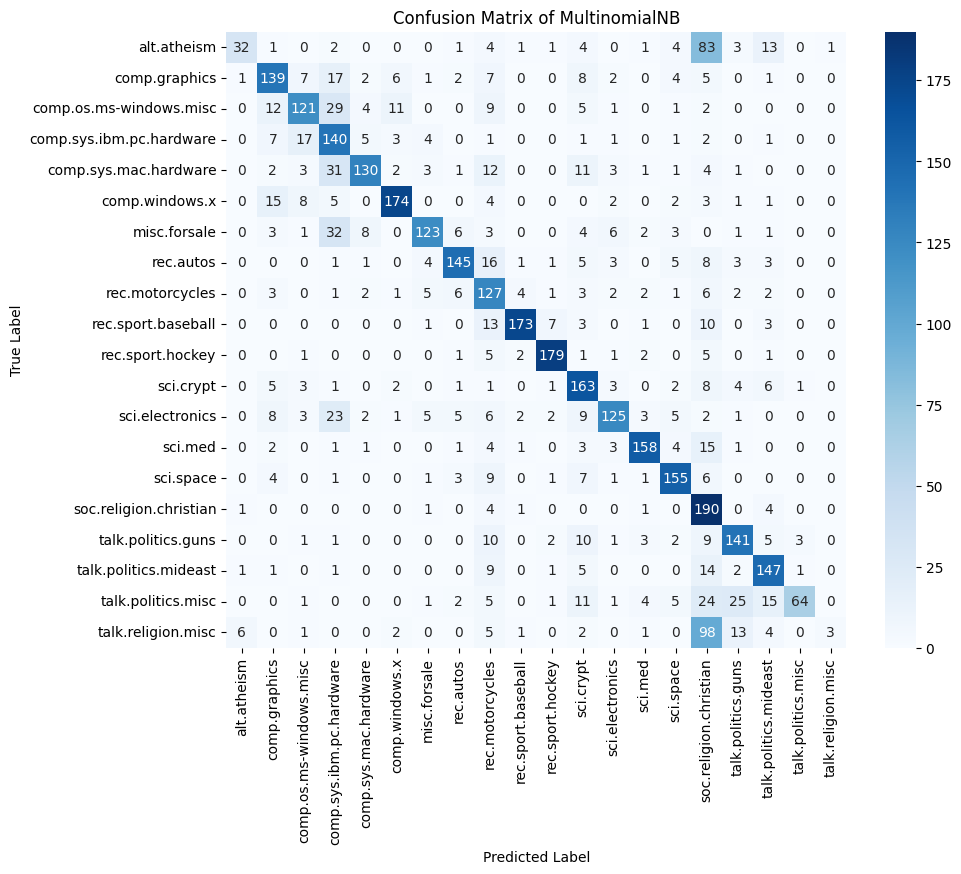

In [19]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=targets_str, yticklabels=targets_str)
plt.title(f'Confusion Matrix of {classifier.__class__.__name__}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Machine learning

In [20]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [21]:
Eval_metrics = dict(
    acc = list(),
    recall = list(),
    f1_score = list()
)

In [22]:

dct = DecisionTreeClassifier()

dct.fit(X_train_vec, y_train)

y_pred = dct.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
Eval_metrics['acc'].append(accuracy)
recall = recall_score(y_test, y_pred, average='macro')
Eval_metrics['recall'].append(recall)
f1 = f1_score(y_test, y_pred, average='macro')
Eval_metrics['f1_score'].append(f1)
print(f"DecisionTree accuracy: {accuracy * 100:.3f}%")
print(f"DecisionTree recall: {recall * 100:.3f}%")
print(f"DecisionTree F1: {f1 * 100:.3f}%")

DecisionTree accuracy: 47.215%
DecisionTree recall: 46.520%
DecisionTree F1: 46.642%


In [23]:
svc = SVC()

svc.fit(X_train_vec, y_train)

y_pred = svc.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
Eval_metrics['acc'].append(accuracy)
recall = recall_score(y_test, y_pred, average='macro')
Eval_metrics['recall'].append(recall)
f1 = f1_score(y_test, y_pred, average='macro')
Eval_metrics['f1_score'].append(f1)
print(f"DecisionTree accuracy: {accuracy * 100:.3f}%")
print(f"DecisionTree recall: {recall * 100:.3f}%")
print(f"DecisionTree F1: {f1 * 100:.3f}%")

DecisionTree accuracy: 72.016%
DecisionTree recall: 70.967%
DecisionTree F1: 70.858%


In [24]:
mnb = MultinomialNB()

mnb.fit(X_train_vec, y_train)

y_pred = mnb.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
Eval_metrics['acc'].append(accuracy)
recall = recall_score(y_test, y_pred, average='macro')
Eval_metrics['recall'].append(recall)
f1 = f1_score(y_test, y_pred, average='macro')
Eval_metrics['f1_score'].append(f1)
print(f"DecisionTree accuracy: {accuracy * 100:.3f}%")
print(f"DecisionTree recall: {recall * 100:.3f}%")
print(f"DecisionTree F1: {f1 * 100:.3f}%")

DecisionTree accuracy: 69.920%
DecisionTree recall: 68.091%
DecisionTree F1: 67.332%


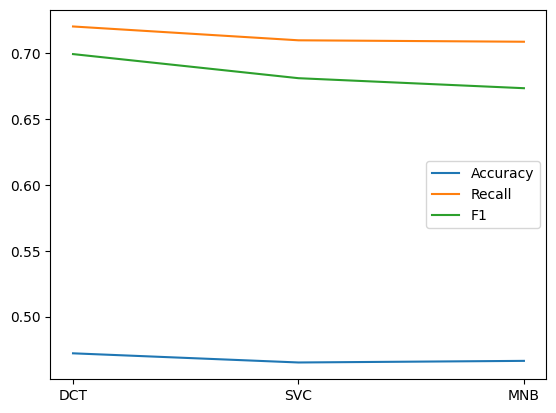

In [52]:
models = ['DCT', 'SVC', 'MNB']
Eval_metricsL = np.array(list(Eval_metrics.values()))
Eval_metricsL

plt.plot(models, Eval_metricsL[:,0], label = "Accuracy")
plt.plot(models, Eval_metricsL[:,1], label = "Recall")
plt.plot(models, Eval_metricsL[:,2], label = "F1")
plt.legend()
plt.show()